# **Importing Libraries**





In [2]:
import matplotlib.pyplot as plt
import pathlib, os, random
import numpy as np
import pandas as pd
import tensorflow as tf
import keras


from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, BatchNormalization, Dropout , GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras import Sequential
from keras.callbacks import Callback, EarlyStopping,ModelCheckpoint

# **How many classes do we have?**

In [3]:
train_path="../input/100-bird-species/train/"
no_birds_classes = os.listdir(train_path)
len(no_birds_classes)

450

**Classes Names**

In [4]:
data_dir = pathlib.Path("../input/100-bird-species/train/")
BirdClasses = np.array(sorted([item.name for item in data_dir.glob("*")]))
print(BirdClasses)

['ABBOTTS BABBLER' 'ABBOTTS BOOBY' 'ABYSSINIAN GROUND HORNBILL'
 'AFRICAN CROWNED CRANE' 'AFRICAN EMERALD CUCKOO' 'AFRICAN FIREFINCH'
 'AFRICAN OYSTER CATCHER' 'AFRICAN PIED HORNBILL' 'ALBATROSS'
 'ALBERTS TOWHEE' 'ALEXANDRINE PARAKEET' 'ALPINE CHOUGH'
 'ALTAMIRA YELLOWTHROAT' 'AMERICAN AVOCET' 'AMERICAN BITTERN'
 'AMERICAN COOT' 'AMERICAN FLAMINGO' 'AMERICAN GOLDFINCH'
 'AMERICAN KESTREL' 'AMERICAN PIPIT' 'AMERICAN REDSTART' 'AMERICAN WIGEON'
 'AMETHYST WOODSTAR' 'ANDEAN GOOSE' 'ANDEAN LAPWING' 'ANDEAN SISKIN'
 'ANHINGA' 'ANIANIAU' 'ANNAS HUMMINGBIRD' 'ANTBIRD' 'ANTILLEAN EUPHONIA'
 'APAPANE' 'APOSTLEBIRD' 'ARARIPE MANAKIN' 'ASHY STORM PETREL'
 'ASHY THRUSHBIRD' 'ASIAN CRESTED IBIS' 'ASIAN DOLLARD BIRD'
 'AUCKLAND SHAQ' 'AUSTRAL CANASTERO' 'AUSTRALASIAN FIGBIRD' 'AVADAVAT'
 'AZARAS SPINETAIL' 'AZURE BREASTED PITTA' 'AZURE JAY' 'AZURE TANAGER'
 'AZURE TIT' 'BAIKAL TEAL' 'BALD EAGLE' 'BALD IBIS' 'BALI STARLING'
 'BALTIMORE ORIOLE' 'BANANAQUIT' 'BAND TAILED GUAN' 'BANDED BROADBILL'
 'BAN

# **Visualizing Images**

In [5]:
def view_random_image(target_dir, target_class):
  
  # setting up the image directory
  target_folder = target_dir + target_class

  #get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  #read image and plotting it
  img = plt.imread(target_folder + "/" + random_image[0] )
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off")

  #print(f"Image shape: {img.shape}")
  
  return img

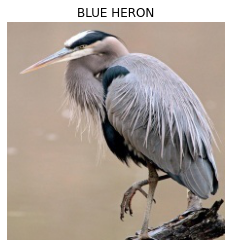

In [6]:
img = view_random_image(train_path,'BLUE HERON')

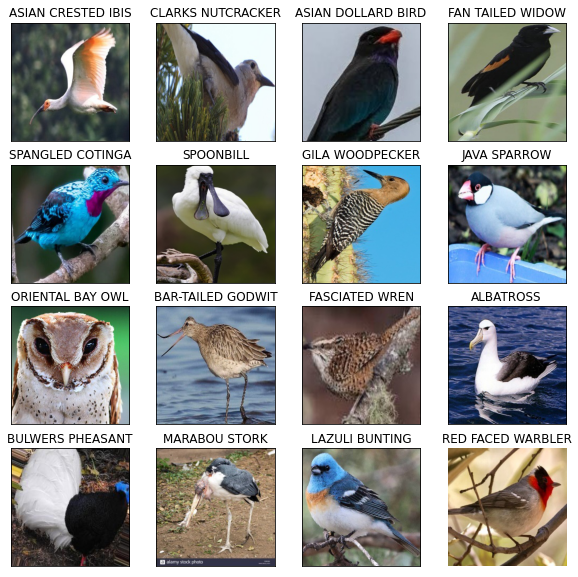

In [7]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

random_index = np.random.randint(0 , len(BirdClasses)-1 , 16)

for i, ax in enumerate(axes.flat):
    ax.imshow(view_random_image(train_path,BirdClasses[random_index[i]]))
    ax.set_title(BirdClasses[random_index[i]])

# **Data Preprocessing**

In [8]:
train_dir = "../input/100-bird-species/train/"
test_dir = "../input/100-bird-species/test/"
val_dir = "../input/100-bird-species/valid/"

In [9]:
from keras.applications.mobilenet_v2 import MobileNetV2

In [10]:
train_gen = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)
val_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_directory( train_dir , target_size=(224,224) , batch_size=32 , class_mode = "categorical" ,shuffle=True )

val_data = val_gen.flow_from_directory( val_dir , target_size=(224,224) , batch_size=32 , class_mode = "categorical" , shuffle=True )

test_data = test_gen.flow_from_directory( test_dir , target_size=(224,224) , batch_size=32 , class_mode = "categorical" ,shuffle=False )


Found 70626 images belonging to 450 classes.
Found 2250 images belonging to 450 classes.
Found 2250 images belonging to 450 classes.


# **Preparing MobileNet Pretrained Model**

In [11]:
mobilenet = MobileNetV2( include_top=False , weights="imagenet" , input_shape=(224,224,3))

mobilenet.summary()

2022-12-18 17:02:40.627142: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-18 17:02:40.712563: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-18 17:02:40.713360: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-18 17:02:40.714656: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

9420800/9406464 [==============================] - 1s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
________________

# **Fine-Tuning MobileNet Model**

In [12]:
# Freezing all layers except the last 20 layers

mobilenet.trainable=True

for layer in mobilenet.layers[:-20]:
  layer.trainable=False

In [13]:
Model = Sequential([
    mobilenet,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(256,activation='relu'),
    BatchNormalization(),
    Dense(450,activation='softmax')
])

Model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1280)              5120      
_________________________________________________________________
dense (Dense)                (None, 256)               327936    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 450)               115650    
Total params: 2,707,714
Trainable params: 1,652,738
Non-trainable params: 1,054,976
______________________________________

In [14]:
Model.compile( optimizer="adam", loss="categorical_crossentropy" , metrics=["accuracy"] )

In [15]:
# Create Callback Checkpoint

#checkpoint_path = "BirdsSpecies_Model_Checkpoint"
#checkpoint_callback = ModelCheckpoint(checkpoint_path,monitor="val_accuracy",save_best_only=True)

callbacks = [EarlyStopping(monitor='val_accuracy' , patience=5 , restore_best_weights=True)]

In [16]:
def myprint(s):
    with open('modelsummary.txt','a') as f:
        print(s, file=f)

Model.summary(print_fn=myprint)

In [17]:
with open('modelsummary.txt', 'w') as f:

    Model.summary(print_fn=lambda x: f.write(x + '\n'))

In [18]:
history = Model.fit(train_data,epochs=15 , batch_size=32 ,steps_per_epoch = len(train_data)
,callbacks=callbacks ,workers=10,use_multiprocessing=True, validation_data=val_data,validation_steps = len(val_data))

2022-12-18 17:02:46.376440: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/15


2022-12-18 17:02:51.471225: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


2208/2208 [==============================] - 267s 116ms/step - loss: 1.3365 - accuracy: 0.6962 - val_loss: 1.0233 - val_accuracy: 0.7360
Epoch 2/15
2208/2208 [==============================] - 231s 104ms/step - loss: 0.5173 - accuracy: 0.8573 - val_loss: 0.6958 - val_accuracy: 0.8222
Epoch 3/15
2208/2208 [==============================] - 228s 102ms/step - loss: 0.3884 - accuracy: 0.8901 - val_loss: 0.8203 - val_accuracy: 0.7920
Epoch 4/15
2208/2208 [==============================] - 219s 98ms/step - loss: 0.2956 - accuracy: 0.9130 - val_loss: 0.3569 - val_accuracy: 0.8969
Epoch 5/15
2208/2208 [==============================] - 247s 111ms/step - loss: 0.2411 - accuracy: 0.9268 - val_loss: 0.2756 - val_accuracy: 0.9213
Epoch 6/15
2208/2208 [==============================] - 233s 105ms/step - loss: 0.1893 - accuracy: 0.9413 - val_loss: 0.2540 - val_accuracy: 0.9387
Epoch 7/15
2208/2208 [==============================] - 239s 107ms/step - loss: 0.1567 - accuracy: 0.9518 - val_loss: 0.3738

In [28]:
history_2 = Model.fit(train_data,epochs=15 , batch_size=32 ,steps_per_epoch = len(train_data)
,callbacks=callbacks ,workers=10,use_multiprocessing=True, validation_data=val_data,validation_steps = len(val_data),
                    initial_epoch=history.epoch[-1] )

Epoch 11/15
2208/2208 [==============================] - 249s 112ms/step - loss: 0.2350 - accuracy: 0.9277 - val_loss: 0.3455 - val_accuracy: 0.9080
Epoch 12/15
2208/2208 [==============================] - 306s 138ms/step - loss: 0.1525 - accuracy: 0.9522 - val_loss: 0.4649 - val_accuracy: 0.8982
Epoch 13/15
2208/2208 [==============================] - 282s 126ms/step - loss: 0.1398 - accuracy: 0.9562 - val_loss: 0.3189 - val_accuracy: 0.9164
Epoch 14/15
2208/2208 [==============================] - 248s 112ms/step - loss: 0.1133 - accuracy: 0.9635 - val_loss: 0.2840 - val_accuracy: 0.9236
Epoch 15/15
2208/2208 [==============================] - 298s 134ms/step - loss: 0.1112 - accuracy: 0.9648 - val_loss: 0.2699 - val_accuracy: 0.9382


# **Evaluating The Model**

In [29]:
results = Model.evaluate(test_data, verbose=0)


print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.21747
Test Accuracy: 94.31%


In [31]:
def plot_curves(history):

  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  #plot loss
  plt.plot(epochs, loss, label = "training_loss")
  plt.plot(epochs, val_loss, label = "val_loss")
  plt.title("Loss")
  plt.xlabel("epochs")
  plt.legend()

  #plot accuracy
  plt.figure() 
  plt.plot(epochs, accuracy, label = "training_accuracy")
  plt.plot(epochs, val_accuracy, label = "val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("epochs")
  plt.legend()
  plt.show()
  plt.tight_layout()

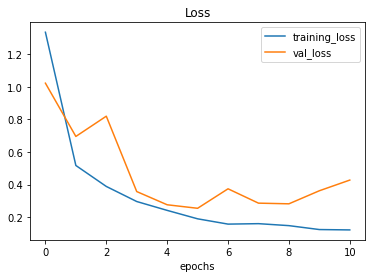

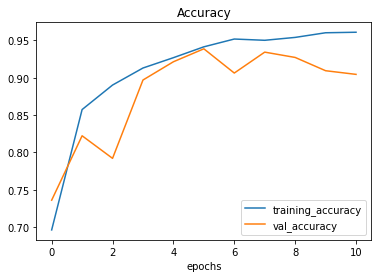

<Figure size 432x288 with 0 Axes>

In [21]:
plot_curves(history)

# **Predicting Test Set**

In [32]:
pred = Model.predict(test_data)
pred = np.argmax(pred,axis=1)

True Label: ALTAMIRA YELLOWTHROAT
Predicted Label: ALTAMIRA YELLOWTHROAT


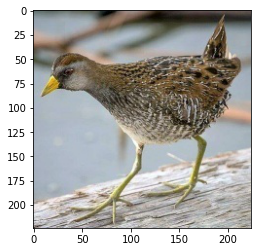

In [33]:
index =62

img , label = test_data[index]
label = test_data.labels[index]
print(f"True Label: {BirdClasses[label]}")
print(f"Predicted Label: {BirdClasses[pred[index]]}")  
plt.imshow(img[0])
plt.show()

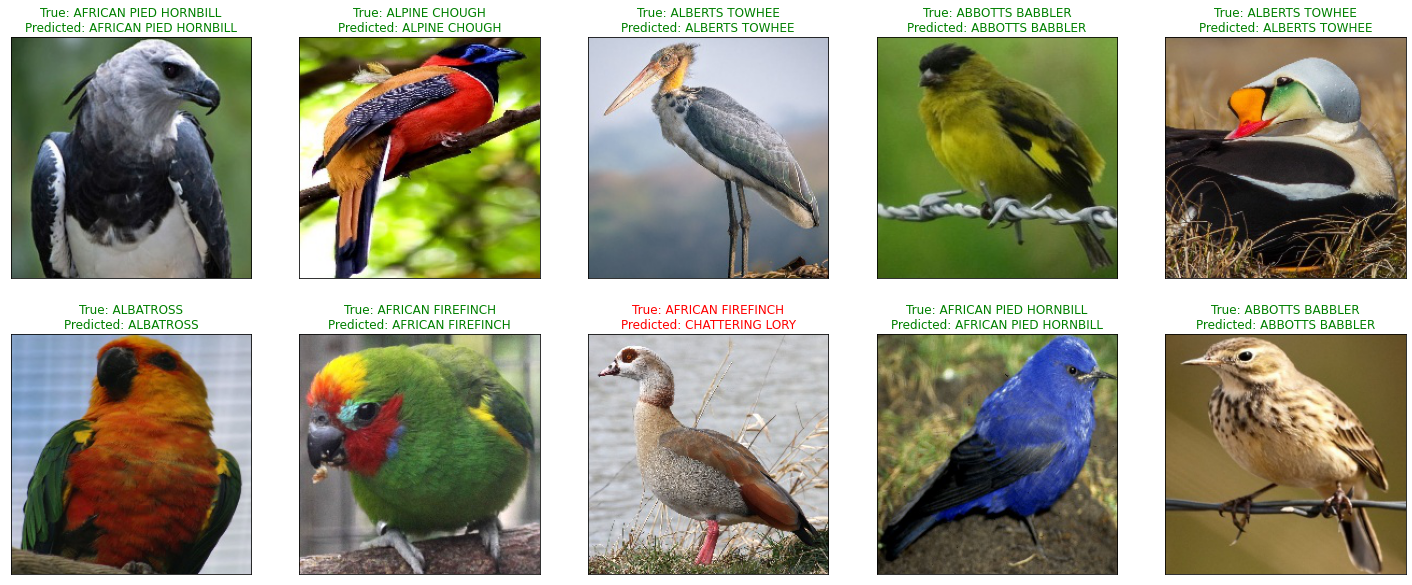

<Figure size 432x288 with 0 Axes>

In [35]:
# Display 10 random pictures from the dataset with their labels

random_index = np.random.randint(0, len(test_data) - 1, 10)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    randImg , randLabel = test_data[random_index[i]]
    randLabel = test_data.labels[random_index[i]]
    ax.imshow(randImg[0])
    if BirdClasses[randLabel] == BirdClasses[pred[random_index[i]]]:
      color = "green"
    else:
      color = "red"
    ax.set_title(f"True: {BirdClasses[randLabel]}\nPredicted: {BirdClasses[pred[random_index[i]]]}", color=color)
plt.show()
plt.tight_layout()

# **Predicting Random Image**

In [36]:
def load_and_prep_image(filename, img_shape = 224):
  img = tf.io.read_file(filename) #read image
  img = tf.image.decode_image(img) # decode the image to a tensor
  img = tf.image.resize(img, size = [img_shape, img_shape]) # resize the image
  img = img/255. # rescale the image
  return img

In [40]:
def pred_and_plot(filename, class_names):

  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = Model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  pred_class = class_names[pred.argmax()]

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

**Predicting image from Flamingo file**

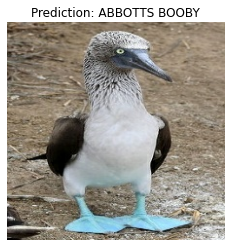

In [43]:
pred_and_plot("../input/100-bird-species/test/ABBOTTS BOOBY/5.jpg", BirdClasses)

Predicting image from EMPEROR PENGUIN file

In [45]:
Model.save("BirdSpecies.h5")

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
